# 外れ値・異常値とは何かを理解し，検出と除去，変換等の対応をする(2022/03/15)
---

## 概要
---

本notebookでは，外れ値・異常値を理解し，それぞれを実際にどのように取り扱うかを学ぶ．

## 外れ値・異常値(outlier)
---

外れ値とは，採取したデータ群の中で極端に大きい(小さい)値をとっていること，あるいは当該標本のことを表す．原因としてデータの測定ミスや入力ミス等原因が明らかな場合，異常値と呼ばれ区別されるが，現実問題として両社が明確に分けて考えられるものではない．

何を根拠として外れ値か否かを判断するのか，これから記す様々な手法が提案されている．ただし共通している考え方としてあるのは「外れ値だと判断したデータをとりあえず取り除くことはあってはならない」という考え方である．異常値のように，原因が明確で当該データを取り除くという場合であっても，実験手順や測定方法に不十分な点がないかを吟味する必要がある．

外れ値だと判定した場合に機械的にそれを除去して統計検定を行うのではなく，根本的に「なぜ外れ値が発生したのか」という視点がデータ解析において重要である．

## 外れ値を客観的に判定する
---

本節では測定者の主観に寄らず，データが外れ値か否かを判定する手法について述べる．繰り返すが，重要なのは機械的に外れ値が判定できるということではなく，外れ値だと判定されたデータがなぜ出現したかを考えることである．

以下に示す定量的な4つの方法以外にも，散布図を作成するなどして直感的に外れ値の存在を把握することができる．

### 箱ひげ図を用いる方法
箱ひげ図では最大値と最小値のデータまで「ひげ」を描くことでデータの分布を表す．このとき，あらかじめ以下の基準にそって外れ値を除外してから「ひげ」を描くことがある．

- $(第三四分位数)+(四分位範囲) \times 1.5$より大きい値のデータ
- $(第一四分位数)-(四分位範囲) \times 1.5$より小さい値のデータ

外れ値とみなされたデータは箱ひげ図の両端に，実際に得られた値のデータ点としてプロットされることが多い．

### 標本標準偏差を用いる方法
標本標準偏差を利用して外れ値を判定する方法がある．

この方法では，データが正規分布に従うことが望ましい．なぜなら標本平均$\mu$を中心として，標本標準偏差を$s$とするとき，$\mu$より左右対称に$\mu\pm3s$(または$\mu\pm 2s$)より外のデータを外れ値とみなすからである．

### スミルノフ・グラブス検定
スミルノフ・グラブス(Smirnov-Grubbs)検定では，正規分布を仮定してあるデータ点が外れ値かどうかを検定する．以下に定義する臨界値$\tau$を超えるデータ1つを外れ値として除外し，臨界値を超えるデータがなくなるまで再帰的に検定を繰り返すのが特徴である．

\begin{eqnarray}
\tau = \frac{(n-1)t}{\sqrt{n(n-2)+nt^2}}
\end{eqnarray}

ここで$n$は標本数，$t$は自由度$n-2$の$t$分布における$a/n\times100$パーセンタイル点である($a$は有意水準)．

### トンプソン検定
トンプソン(Tompson)検定では，以下に示す臨界値から外れ値を検定する．標本数$n$が十分に大きければ，結果はスミルノフ・グラブス検定と同様になる．

\begin{eqnarray}
t=\frac{\tau\sqrt{n-2}}{\sqrt{n-1-\tau^2}}
\end{eqnarray}

## Pythonを用いたシミュレーション
---

今回はテストの点数に見立てた0-100の値をとる一次元データを用いて，これまで述べた「箱ひげ図を用いる方法」「標本標準偏差を用いる方法」「スミルノフ・グラブス検定」を行ってみる．

### 箱ひげ図を用いる方法

In [1]:
# 95人の得点に5人分の外れ値を紛れ込ませたデータ
import pandas as pd
import seaborn as sns
import numpy as np

np.random.seed(0)

values = np.random.randint(low=40, high=60, size=95)
outlier = np.array([1, 2, 3, 99, 100])

point_data = pd.Series(np.concatenate((values, outlier)))
point_data

0      52
1      55
2      40
3      43
4      43
     ... 
95      1
96      2
97      3
98     99
99    100
Length: 100, dtype: int64

<AxesSubplot:>

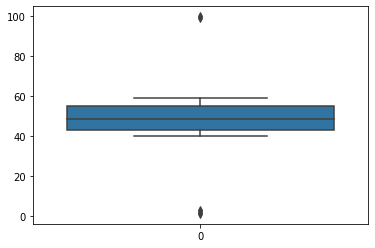

In [2]:
# seabornを用いてひとまず箱ひげ図を作成
# パラメータwhisで四分位範囲に掛ける係数を指定できる
sns.boxplot(data=point_data, whis=1.5)

外れ値が黒点としてプロットされている様子が確認できる．

In [3]:
# 四分位範囲を計算して，外れ値を除外してから再度箱ひげ図を作成する
iqr = point_data.quantile(0.75) - point_data.quantile(0.25)

l_thresh = point_data.quantile(0.25) - iqr * 1.5
h_thresh = point_data.quantile(0.75) + iqr * 1.5

point_data_iqr = point_data[l_thresh < point_data]
point_data_iqr = point_data_iqr[point_data < h_thresh]
point_data_iqr

0     52
1     55
2     40
3     43
4     43
      ..
90    45
91    40
92    57
93    58
94    44
Length: 95, dtype: int64

<AxesSubplot:>

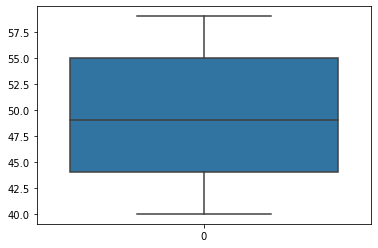

In [4]:
sns.boxplot(data=point_data_iqr, whis=1.5)

### 標本標準偏差を用いる方法

In [5]:
# 標本平均と標本標準偏差(不偏分散から)を計算

mean = point_data.mean()
std = point_data.std()

l_thresh = mean-3*std
h_thresh = mean+3*std

print('mean: ', mean)
print('std: ', std)
print('l_thresh: ', l_thresh)
print('h_thresh: ', h_thresh)

mean:  48.6
std:  12.421063894966014
l_thresh:  11.336808315101955
h_thresh:  85.86319168489806


In [6]:
# 閾値を外れるデータを除去して箱ひげ図を作成
point_data_std = point_data[l_thresh < point_data]
point_data_std = point_data_std[point_data < h_thresh]
point_data_std

0     52
1     55
2     40
3     43
4     43
      ..
90    45
91    40
92    57
93    58
94    44
Length: 95, dtype: int64

<AxesSubplot:>

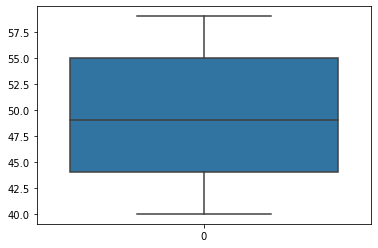

In [7]:
sns.boxplot(data=point_data_std, whis=1.5)

### スミルノフ・グラブス検定

優位水準5%で検定を行う．

In [8]:
point_data

0      52
1      55
2      40
3      43
4      43
     ... 
95      1
96      2
97      3
98     99
99    100
Length: 100, dtype: int64

In [9]:
from scipy.stats import t


a = 0.05

while True:
    point_data.reset_index(inplace=True, drop=True)
    n = point_data.shape[0]
    mean = point_data.mean()
    std = point_data.std()

    pp = t.ppf(q=a/n, df=n-2, loc=mean, scale=std)
    tau = (n-1)*pp / np.sqrt(n*(n-2) + n*pp**2)
    
    max_index, min_index = point_data.argmax(), point_data.argmin()
    max_value, min_value = point_data.max(), point_data.min()
    print(n, tau, max_index, max_value, min_index, min_value)
    
    if (max_value-mean) > (mean-min_value):
        if max_value > (mean+tau):
            print(point_data.pop(max_index))
        else:
            break
    else:
        if min_value < (mean-tau):
            print(point_data.pop(min_index))
        else:
            break

100 5.410550222090338 99 100 95 1
100
99 6.884776645200621 98 99 95 1
99
98 7.863510205240609 7 59 95 1
1
97 8.518323960976046 7 59 95 2
2
96 8.898839886987941 7 59 95 3
3
95 9.124831313484089 7 59 2 40
59
94 9.083895593646174 20 59 2 40
59
93 9.04285095694681 21 59 2 40
59
92 9.001697086827026 28 59 2 40
59
91 8.960433579085633 28 59 2 40
59
90 8.919059948693949 28 59 2 40
59
89 8.877575644729383 7 58 2 40
58
88 8.834331157114134 24 58 2 40
58
87 8.790940524539744 35 58 2 40
58
86 8.747403070144362 55 58 2 40
58
85 8.703718118026645 83 58 2 40
58
84 8.659885031006477 14 57 2 40
57
83 8.614355404110537 24 57 2 40
57
82 8.568640121261549 40 57 2 40
57
81 8.522738214800013 72 57 2 40
57
80 8.476648838503289 78 57 2 40
57
79 8.430371344658594 18 56 2 40
56
78 8.382448567970103 70 56 2 40
56
77 8.334297593615267 1 55 2 40


<AxesSubplot:>

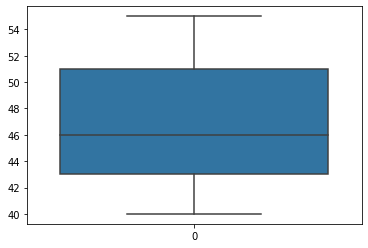

In [10]:
sns.boxplot(data=point_data, whis=1.5)

スミルノフ・グラブス検定に関しては，実装された手順に誤りがある...かも?

## 参考文献
---

[32-1. 外れ値，統計WEB](https://bellcurve.jp/statistics/course/12929.html#:~:text=%E5%A4%96%E3%82%8C%E5%80%A4%E3%81%A8%E3%81%AF%E3%80%81%E5%BE%97,%E3%81%8C%E7%95%B0%E5%B8%B8%E5%80%A4%E3%81%A8%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82)

[外れ値，Wikipedia](https://ja.wikipedia.org/wiki/%E5%A4%96%E3%82%8C%E5%80%A4)

[外れ値と判定する方法と、外れ値の除去について，統計学がわかった！](https://toukeigaku-jouhou.info/2018/04/25/determine-outlier/)

[外れ値とはどんな定義で求め方は？統計的検定で除外するのがいいの？，いちばんやさしい、医療統計](https://best-biostatistics.com/summary/outlier.html)

[統計一口メモ　第12話 「外れ値をかってに外してはいけないって言われるけど」，安全性評価研究会](https://tanigaku.jp/wp/?p=3158)

[外れ値　outlier，一般社団法人　日本理学療法学会連合](http://jspt.japanpt.or.jp/ebpt_glossary/outlier.html)

[外れ値検出について，tk.tatsuro.note](https://note.com/tatsu321/n/n0a4d64ea554b)

[Python初心者向け：四分位数/標準偏差を用いた外れ値の除外，Happy Analysis](https://happy-analysis.com/python/python-topic-outlier.html)

[データに含まれる異常値を検出してみよう，Qiita](https://qiita.com/papi_tokei/items/6f77a2a250752cfa850b)

[【pandas】外れ値を確認・除去する方法【df.quantile()】，self-methods](https://self-methods.com/pandas-quantile/)